# Marks

In [11]:
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [22]:
def format(session):
    # Read the file with violin's marks
    df = pd.read_csv(
        f"/home/hugo/Thèse/playing-in/data/raw/CNSM/Ouverture par le jeu/notes/Liste participant⋅es - Session {session}.csv"
    )

    # Drop unnecessary columns for ANOVA
    df = df.drop(
        [
            "Jour",
            "Horaire",
            "Ord 1",
            "Ord 2",
            "Rq A",
            "Rq B",
            "Rq C",
            "Rq D",
            "Rq E",
            "Unnamed: 26",
        ],
        axis="columns",
    )

    # Split columns name for A.P A.F ...
    columns_split = np.array([col.split(".") for col in df.columns[2:]])
    tiles = np.tile(columns_split, (len(df), 1))

    # Create a new dataframe with splitted columns as values
    df_long = pd.DataFrame(tiles, columns=["Violon", "Critère"])

    # Add the values back
    df_long["Note"] = df.iloc[:, 2:].values.flatten()

    # Add the first column back
    df_long["Condition"] = "aveugle"
    # df_long['Condition'] = df['Condition 1'].repeat(len(df.columns) - 2).values
    df_long["Sujet"] = df["Nom"].repeat(len(df.columns) - 2).values
    df_long["Session"] = session

    df_long.loc[df_long["Violon"] == "D", "Condition"] = "non-aveugle"
    df_long.loc[df_long["Violon"] == "D", "Violon"] = "A"
    df_long.loc[df_long["Violon"] == "E", "Condition"] = "non-aveugle"
    df_long.loc[df_long["Violon"] == "E", "Violon"] = "B"

    df_long.to_csv(f"session{session}.csv")

    return df_long


df1 = format(1)
df2 = format(2)
df3 = format(3)
df = pd.concat([df1, df2, df3])
df = df.replace({"A": "Klimke", "B": "Levaggi", "C": "Stopanni"})

## Plots

['Paul' 'Renato' 'Areski' 'Félix' 'Céleste' 'SMD' 'Hélène' 'Clara'
 'Norimi' 'Fanton' 'Lucie' 'Eugénie' 'Victor']


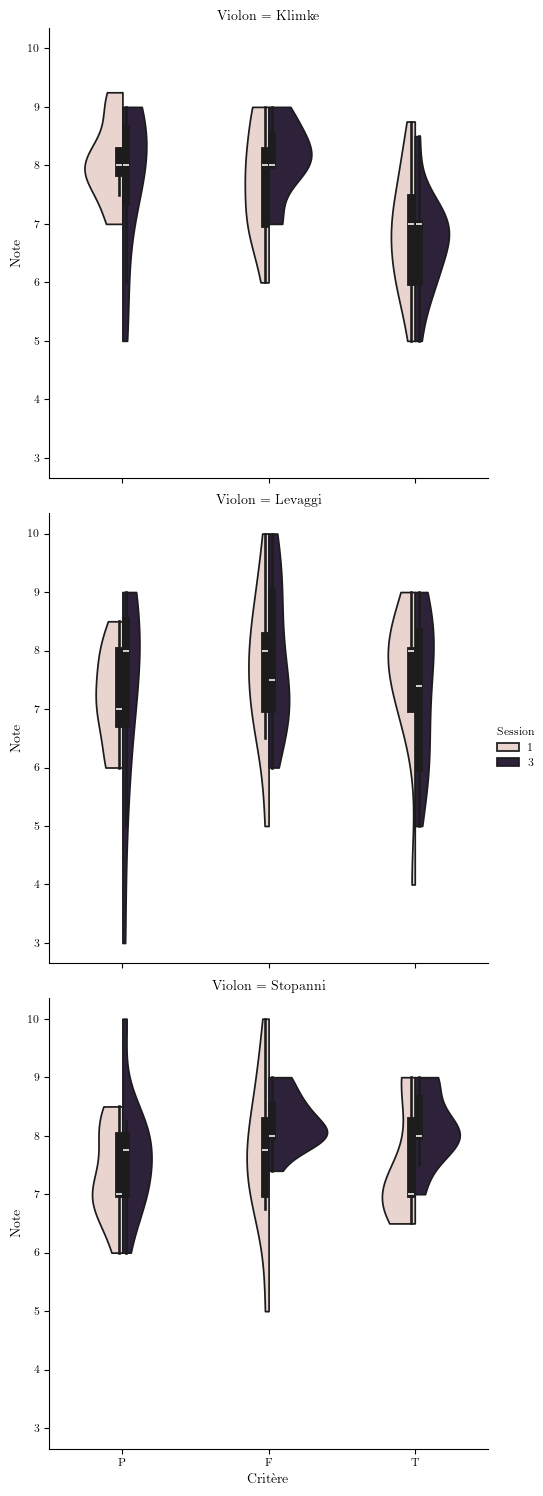

In [30]:
plt_df = df[(df.Condition == "aveugle") & (df.Session != 2)]
print(plt_df["Sujet"].unique())

sns.catplot(
    data=plt_df,
    row="Violon",
    x="Critère",
    y="Note",
    hue="Session",
    split=True,
    common_norm=True,
    legend="auto",
    kind="violin",
    cut=0,
)

/tmp/ipykernel_49549/1271857722.py:1: FutureWarning: The provided callable <function std at 0x7f2a723cf4c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  groups = plt_df.groupby(by=["Violon", "Critère", "Session"], sort=False)["Note"].agg(
/tmp/ipykernel_49549/1271857722.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


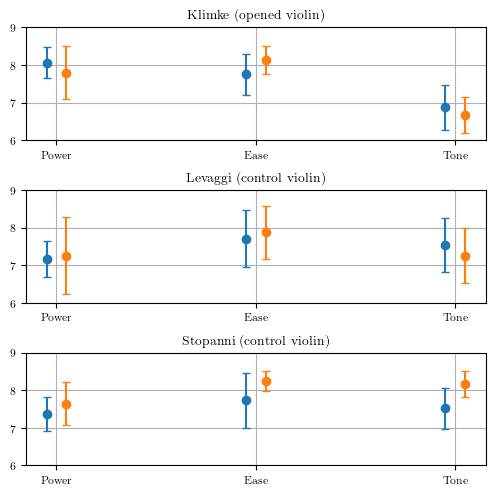

In [48]:
groups = plt_df.groupby(by=["Violon", "Critère", "Session"], sort=False)["Note"].agg(
    ["mean", np.std, "count"]
)

mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, axs = plt.subplots(3, figsize=(5, 5))

for i, (violin, a) in enumerate(groups.groupby(level=0, sort=False)):
    a = a.droplevel(0)
    for j, (critere, b) in enumerate(a.groupby(level=0, sort=False)):
        b = b.droplevel(0)
        for k, (session, c) in enumerate(b.groupby(level=0, sort=False)):
            margin = 0.05
            offset = margin if session == 3 else -margin
            axs[i].errorbar(
                j + offset,
                c["mean"],
                yerr=1.96 / np.sqrt(c["count"]) * c["std"],
                fmt="o",
                color="C0" if session != 3 else "C1",
                capsize=3,
            )
    axs[i].set_xticks([0, 1, 2], ["Power", "Ease", "Tone"])
    axs[i].set_title(
        f"{violin}{" (opened violin)" if violin == "Klimke" else " (control violin)"}"
    )
    axs[i].set_ylim([6, 9])
    axs[i].grid()
fig.show()
fig.savefig("../reports/figures/marks.png")

## Statistical Test

In [31]:
df = df[(df.Condition == "aveugle") & (df.Violon == "A") & (df.Session != 2)]

# Delete empty rows
df = df[df["Note"] > 0]

# Keep only subjects who participated in all sessions
sujets1 = set(df.query("Session==1")["Sujet"])
sujets2 = set(df.query("Session==3")["Sujet"])
sujets3 = set(df.query("Session==3")["Sujet"])
df = df[df["Sujet"].isin(sujets1.intersection(sujets2, sujets3))]

# Delete third violin
# df = df[df.Violon != "C"]
# df.to_csv(f"session.csv")

print(df["Sujet"].value_counts())

# Define the relevant factors
factors = ["Critère", "Session"]

# For each factor, list the unique levels and the count of occurrences for each level
factor_levels = {factor: df[factor].value_counts() for factor in factors}

# Display the shape of each level
for factor, levels in factor_levels.items():
    print(f"Factor: {factor}")
    print(levels)
    print("\n")


# Définir l'ANOVA répétée
anova = AnovaRM(df, "Note", "Sujet", within=factors)

# Compute ANOVA
resultats = anova.fit()
resultats.anova_table = np.round(resultats.anova_table, 3)
resultats.anova_table["Num DF"] = resultats.anova_table["Num DF"].astype("int")
resultats.anova_table["Den DF"] = resultats.anova_table["Den DF"].astype("int")

# Afficher les résultats
print(resultats.anova_table)

resultats.anova_table.to_html("anova.html", justify="unset", border=0)

# anova = pg.anova(data=df, dv='Note', between=['Session', 'Condition', 'Violon', 'Critère'], ss_type=2).round(3)
# anova = anova.set_index('Source')
# anova.to_html('anova.html', justify='unset', float_format='{:10.2f}'.format, border=0)
# print(anova)

Sujet
Paul       6
Renato     6
Areski     6
Félix      6
Céleste    6
SMD        6
Clara      6
Norimi     6
Fanton     6
Lucie      6
Eugénie    6
Name: count, dtype: int64
Factor: Critère
Critère
P    22
F    22
T    22
Name: count, dtype: int64


Factor: Session
Session
1    33
3    33
Name: count, dtype: int64


                 F Value  Num DF  Den DF  Pr > F
Critère           11.303       2      20   0.001
Session            0.341       1      10   0.572
Critère:Session    1.523       2      20   0.242
